In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import root
import matplotlib.pyplot as plt

In [2]:
g = 1.622 # m/sec^2
m_0 = 4700.0 # kg
f = 16000.0 # N
i_sp = 311.0 #sec
v_exhaust = 9.8 * i_sp # m/sec
b = f / v_exhaust# kg/sec
mass_fraction = 2353.0/m_0 # dimensionless

In [3]:
m_0/b

895.2912500000001

In [4]:
def func(state,t):
    x,y = state[0], state[1]
    p_x, p_y = state[2], state[3]
    psi_x, psi_y = state[4], state[5]
    psi_p_x, psi_p_y = state[6], state[7]
    
    if t > m_0/b*mass_fraction:
        m = m_0*(1.0 - mass_fraction)
        phi = np.arctan(p_y/p_x)
        return np.array([p_x/m, p_y/m, 0.0, -m*g, 0.0, 0.0, 0.0, 0.0])
    
    else:
        m = m_0 - b * t
        #phi = np.arctan2(p_y - m*psi_p_y , p_x -  m*psi_p_x)
        phi = np.arctan((p_y - m*psi_p_y)/(p_x -  m*psi_p_x))
    
        return np.array([p_x/m,
                         p_y/m,
                         f*np.cos(phi),
                         f*np.sin(phi) - m*g,
                         0.0,
                         -b*g,
                         -b*p_x/m**2+f/m*np.cos(phi) - psi_x/m,
                         -b*p_y/m**2+f/m*np.sin(phi) - psi_y/m
                        ])

In [5]:
def find_altitude_and_speed(
        p_x_0, p_y_0, x_0, y_0, 
        psi_x_0, psi_y_0, psi_p_x_0, psi_p_y_0,
        n, checking_interval, tol):
    
    state_0 = np.array([x_0, y_0, p_x_0, p_y_0, psi_x_0, psi_y_0, psi_p_x_0, psi_p_y_0])

    
    t_interval_start = 0.0
    p_y_f = float('inf') 
    
    while np.abs(p_y_f) > tol:
        #print("New interation starting at t={0}".format(t_interval_start))
        T = np.linspace(t_interval_start, t_interval_start+checking_interval, n)
        states = odeint(func, state_0, T)
        p_y_f = states[-1,3]
        
        if p_y_f > 0:
            t_interval_start = t_interval_start + checking_interval
            state_0 = states[-1,:]
        else:
            i_first_negative_vertical_momentum = np.argmax(states[:,3]<0)
            i_last_positive_vertical_momentum = i_first_negative_vertical_momentum - 1
            t_interval_start = T[i_last_positive_vertical_momentum]
            checking_interval = T[i_first_negative_vertical_momentum] - t_interval_start
            
    m = (m_0 - b*(t_interval_start + checking_interval))
    
    info_dict = {}
    info_dict['climb_time'] = t_interval_start + checking_interval
    info_dict['final_altitude'] = states[-1,1]
    info_dict['final_speed'] = states[-1,2]
    info_dict['final_angle'] = np.arctan((states[-1,3] - m*states[-1, 7])/(states[-1,2] - m*states[-1,6]))
    return info_dict

In [6]:
def find_costates(
    x_0, y_0, p_x_0, p_y_0,
    initial_angle,
    desired_altitude,
    desired_speed,
    desired_angle_at_altitude,
    guess_psi_x_0,
    guess_psi_y_0,
    guess_psi_p_x_0,
    n, checking_interval, tol,
    printing=False):
    
    def minimizee(a):
        psi_x_0 = a[0]
        psi_y_0 = a[1]
        psi_p_x_0 = a[2]
        psi_p_y_0 = p_y_0/m_0 + np.tan(initial_angle)*(psi_p_x_0 - p_x_0/m_0)
        results = find_altitude_and_speed(
            p_x_0, p_y_0, x_0, y_0, 
            psi_x_0, psi_y_0, psi_p_x_0, psi_p_y_0,
            n, checking_interval, tol)
        
        if printing:
            print("------")
            print("Parameters")
            print("psi_x_0: {0}".format(a[0]))
            print("psi_y_0: {0}".format(a[1]))
            print("psi_p_x_0: {0}".format(a[2]))
            print("Results")
            print("final altitude: {0} (desired was {1})".format(results['final_altitude'], desired_altitude))
            print("final speed: {0} (desired was {1})".format(results['final_speed'], desired_speed))
            print("final angle: {0} (desired was {1})".format(results['final_angle'], desired_angle_at_altitude))
        
        return np.array([results['final_altitude'] - desired_altitude,
                         results['final_speed'] - desired_speed,
                         results['final_angle'] - desired_angle_at_altitude])
    
    
    return root(minimizee, np.array([guess_psi_x_0, guess_psi_y_0, guess_psi_p_x_0]))

In [7]:
initial_angle = 0.44*np.pi

In [8]:
no_burn_time = 0.001*m_0/b

In [9]:
p_x_0 = f/m_0*no_burn_time*np.cos(initial_angle)
p_y_0 = f/m_0*no_burn_time*np.sin(initial_angle)

In [10]:
x_0 = 0.5*f/m_0*no_burn_time**2*np.cos(initial_angle)
y_0 = 0.5*(f/m_0 - g)*no_burn_time**2*np.sin(initial_angle)

In [11]:
psi_x_0 = 1.0
psi_y_0 = 0.0

In [12]:
A = np.array([[m_0*(m_0*g - psi_y_0),
                  m_0*psi_x_0],
              [m_0*np.tan(initial_angle), -m_0]])
B = np.array([psi_x_0*p_y_0 - p_x_0*psi_y_0 + p_x_0*m_0*g, 
              -(p_y_0 -p_x_0*np.tan(initial_angle))])
x = np.linalg.solve(A,B)
psi_p_x_0 = x[0]
psi_p_y_0 = x[1]

In [13]:
psi_p_x_0 = -6.0
psi_p_y_0 = p_y_0/m_0 + np.tan(initial_angle)*(psi_p_x_0 - p_x_0/m_0)

In [14]:
psi_p_x_0

-6.0

In [15]:
psi_p_y_0

-31.453101486679042

In [16]:
p_x_0 - m_0*psi_p_x_0

28200.571100770594

{'final_speed': 111265.6893384135, 'final_altitude': 97.227101301878619, 'final_angle': -1.0250556540572042, 'climb_time': 13.11082923497597}


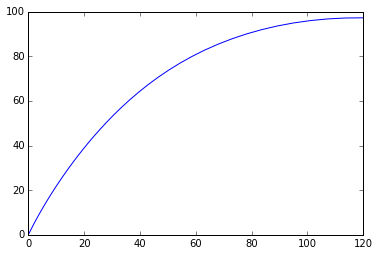

In [17]:
initial_angle = 0.44*np.pi
no_burn_time = 0.001*m_0/b
p_x_0 = f/m_0*no_burn_time*np.cos(initial_angle)
p_y_0 = f/m_0*no_burn_time*np.sin(initial_angle)
x_0 = 0.5*f/m_0*no_burn_time**2*np.cos(initial_angle)
y_0 = 0.5*(f/m_0 - g)*no_burn_time**2*np.sin(initial_angle)
psi_x_0 = -5.0
psi_y_0 = 10.0
psi_p_x_0 = -3.0
psi_p_y_0 = p_y_0/m_0 + np.tan(initial_angle)*(psi_p_x_0 - p_x_0/m_0)
results = find_altitude_and_speed(
    p_x_0, p_y_0, x_0, y_0,
    psi_x_0, psi_y_0, psi_p_x_0, psi_p_y_0,
    20, 1.0, 1e-4)
print(results)

state_0 = np.array([x_0, y_0, p_x_0, p_y_0, psi_x_0, psi_y_0, psi_p_x_0, psi_p_y_0])
T = np.linspace(0, results['climb_time'])
states = odeint(func, state_0, T)

plt.subplots()
plt.plot(states[:,0], states[:,1])

In [18]:
find_costates(
    x_0, y_0, p_x_0, p_y_0,
    0.45*np.pi,
    86.0, #desired final altitude(m)
    320.0, #desired speed (m/s)
    -0.40, # desired angle at altitude (radians)
    -1.477,
    25.8,
    -1.89,
    20, 1.0, 1e-4)

/home/chris/.anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


  status: 5
 success: False
     qtf: array([ -2.2425566 , -83.93371596,  13.09007208])
    nfev: 39
       r: array([  2.20998220e-04,   1.94010410e-04,   5.13079633e+01,
        -4.55754861e-06,  -1.25191144e+00,   1.88528808e-09])
     fun: array([-84.96877339,   0.44159208,  -1.16336972])
       x: array([ -1.78578575e+08,   5.46150245e+09,  -1.98838591e+04])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    fjac: array([[  2.12390946e-02,  -9.99768492e-01,  -3.44438556e-03],
       [  9.89852949e-01,   2.15123511e-02,  -1.40457674e-01],
       [ -1.40499254e-01,   4.26241387e-04,  -9.90080693e-01]])

In [19]:
initial_angle

1.382300767579509

In [20]:
np.arctan((p_y_0 - psi_p_y_0*m_0)/(p_x_0 - psi_p_x_0*m_0))

1.3823007675795089

In [21]:
np.ceil(1.2)

2.0

In [22]:
v = np.array([1.0, 0.3, -0.2, -0.6])
v[v<0][0]

-0.20000000000000001

In [23]:
np.argmax(v<0)

2

In [24]:
state_0 = np.array([x_0, y_0, p_x_0, p_y_0, psi_x_0, psi_y_0, psi_p_x_0, psi_p_y_0])
state_0

array([  0.25565076,   0.70162832,   0.57110077,   2.99381508,
        -5.        ,  10.        ,  -3.        , -15.72655074])

In [25]:
state_0.dtype

dtype('float64')

In [26]:
T = np.linspace(0, 5.873, 10000)

In [27]:
T.dtype

dtype('float64')

In [28]:
States = odeint(func, state_0, T)

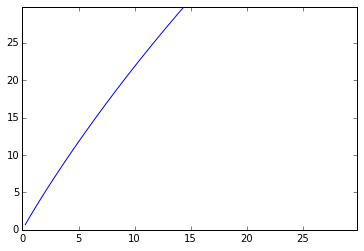

In [29]:
plt.plot(States[:,0], States[:,1])
box_size = max([np.max(States[:,0]), np.max(States[:,1])])
plt.axis([0, box_size, 0, box_size]);

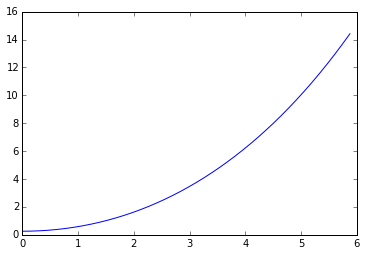

In [30]:
plt.plot(T, States[:,0])

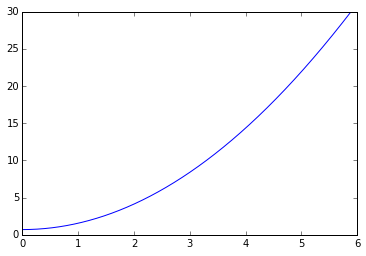

In [31]:
plt.plot(T, States[:,1])

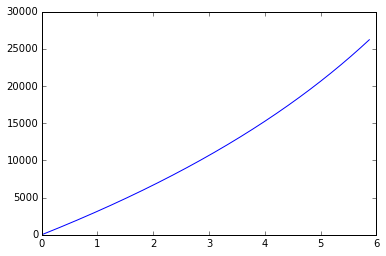

In [32]:
plt.plot(T, States[:,2])

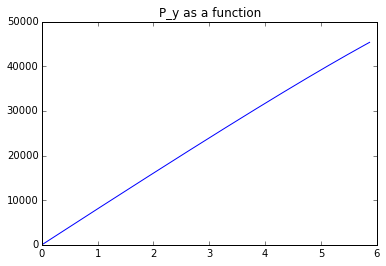

In [33]:
plt.plot(T, States[:,3])
plt.title("P_y as a function")

In [34]:
m = m_0 - b*T

In [35]:
Heading = np.arctan((-States[:,7]*m + States[:,3])/( - States[:,6]*m + States[:,2]))

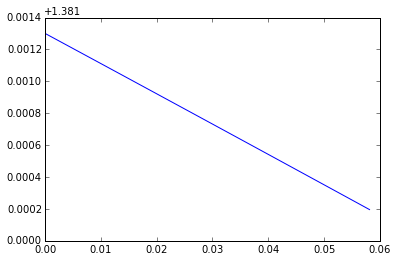

In [36]:
plt.plot(T[:100], Heading[:100])

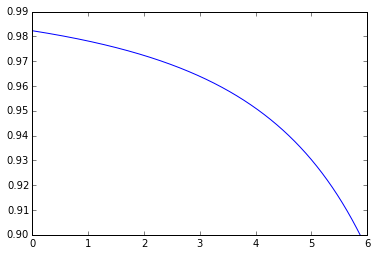

In [37]:
plt.plot(T, np.sin(Heading))

In [38]:
from scipy.optimize import fsolve
fsolve(np.cos, 1.5)

array([ 1.57079633])

In [39]:
def test(x):
    if x[0] > 1.55:
        return np.array([float('inf'), np.exp(x[0]) - x[1]])
    else:
        return np.array([x[1]*np.cos(x[0]), np.exp(x[0]) - x[1]])

In [40]:
from scipy.optimize import root
root(test, np.array([1.5, 3.0]))

  status: 5
 success: False
     qtf: array([ 1.11440235, -0.99927157])
    nfev: 15
       r: array([ nan,  nan,  nan])
     fun: array([ 0.21221161,  1.48168907])
       x: array([ 1.5,  3. ])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    fjac: array([[ nan,  nan],
       [ nan,  nan]])